In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from random import randrange

from tensorflow.keras import Input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling

In [59]:
BATCH_SIZE = 128
IMG_SIZE = (160, 160)
directory = "dataset/"
seed = randrange(100)
print('seed:', seed)
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=seed)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=seed)



seed: 2
Found 2228 files belonging to 2 classes.
Using 1783 files for training.
Found 2228 files belonging to 2 classes.
Using 445 files for validation.


In [60]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(Rescaling(1/255))
    ### END CODE HERE
    
    return data_augmentation

In [52]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [53]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [54]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 1000)


In [55]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.41779572),
  ('n03733281', 'maze', 0.036377195)],
 [('n09229709', 'bubble', 0.5056754),
  ('n03868863', 'oxygen_mask', 0.16305135)],
 [('n03627232', 'knot', 0.08852241), ('n02892767', 'brassiere', 0.041775007)],
 [('n02708093', 'analog_clock', 0.10386336),
  ('n03271574', 'electric_fan', 0.045069784)],
 [('n04589890', 'window_screen', 0.3556968),
  ('n03485794', 'handkerchief', 0.110240184)],
 [('n04589890', 'window_screen', 0.2473735),
  ('n03887697', 'paper_towel', 0.07871627)],
 [('n04589890', 'window_screen', 0.37057006),
  ('n03887697', 'paper_towel', 0.044552136)],
 [('n03733281', 'maze', 0.28829417),
  ('n03271574', 'electric_fan', 0.08547565)],
 [('n03271574', 'electric_fan', 0.2087651),
  ('n07742313', 'Granny_Smith', 0.13026068)],
 [('n01930112', 'nematode', 0.15670557), ('n03733281', 'maze', 0.04777377)],
 [('n03868863', 'oxygen_mask', 0.18651433),
  ('n01496331', 'electric_ray', 0.093734145)],
 [('n03271574', 'electric_fan', 0.2264323),
  

In [68]:
def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = Input(shape=input_shape)
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training = False)
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(rate = 0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [70]:
model1 = model()
model1.summary()
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model1.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0   

KeyboardInterrupt: 

In [5]:
layer_names = [layer.name for layer in model.layers]
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dense_1',
 'dense_2']

In [6]:
model.layers

In [8]:
layer_outputs = [layer.output for layer in model.layers]

layer_outputs

[<KerasTensor: shape=(None, 148, 148, 8) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 74, 74, 8) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 36, 36, 16) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 17, 17, 32) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 9248) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_2')>]

In [11]:
feature_map_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

In [23]:
feature_map_model.layers

In [24]:
layer_outputs = [layer.output for layer in feature_map_model.layers]

layer_outputs

[<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'conv2d_input')>,
 <KerasTensor: shape=(None, 148, 148, 8) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 74, 74, 8) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 36, 36, 16) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 17, 17, 32) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 9248) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_2')>]

In [18]:
image_path= r"Test.png"
img = load_img(image_path, target_size=(150, 150))  
input1 = img_to_array(img)                           
input1 = input1.reshape((1,) + input1.shape)                   
input1 /= 255.0
input1.shape

(1, 150, 150, 3)

In [22]:
feature_maps = feature_map_model.predict(input1)
feature_maps

[array([[[[0.        , 0.03152514, 0.        , ..., 0.13364911,
           0.02293813, 0.        ],
          [0.        , 0.03141088, 0.        , ..., 0.13291013,
           0.02100522, 0.        ],
          [0.        , 0.03224131, 0.        , ..., 0.13290733,
           0.01959067, 0.        ],
          ...,
          [0.        , 0.30992416, 0.        , ..., 1.2087077 ,
           0.17228174, 0.        ],
          [0.        , 0.44850272, 0.        , ..., 1.4472957 ,
           0.05871117, 0.        ],
          [0.        , 0.40994233, 0.        , ..., 1.830657  ,
           0.38882583, 0.        ]],
 
         [[0.        , 0.03134882, 0.        , ..., 0.13211568,
           0.02229712, 0.        ],
          [0.        , 0.03134768, 0.        , ..., 0.1315703 ,
           0.02126166, 0.        ],
          [0.        , 0.03275272, 0.        , ..., 0.13313355,
           0.02015066, 0.        ],
          ...,
          [0.        , 0.30906644, 0.        , ..., 1.2217598 ,
   

In [21]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d is =======>> (1, 148, 148, 8)
The shape of the max_pooling2d is =======>> (1, 74, 74, 8)
The shape of the conv2d_1 is =======>> (1, 72, 72, 16)
The shape of the max_pooling2d_1 is =======>> (1, 36, 36, 16)
The shape of the conv2d_2 is =======>> (1, 34, 34, 32)
The shape of the max_pooling2d_2 is =======>> (1, 17, 17, 32)
The shape of the flatten is =======>> (1, 9248)
The shape of the dense is =======>> (1, 1024)
The shape of the dense_1 is =======>> (1, 512)
The shape of the dense_2 is =======>> (1, 3)


553476096/553467096 [==============================] - 63s 0us/step


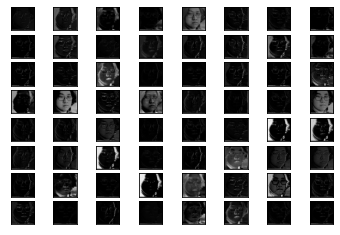

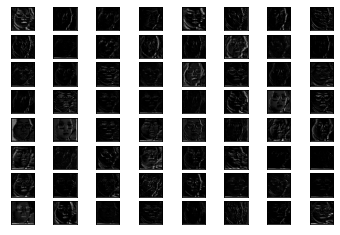

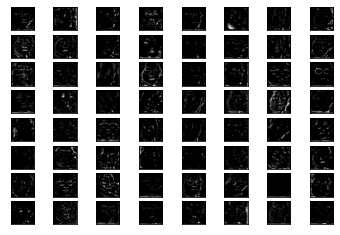

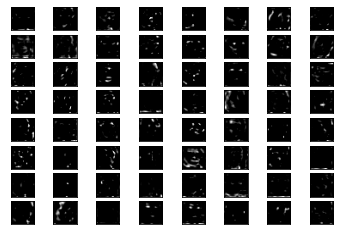

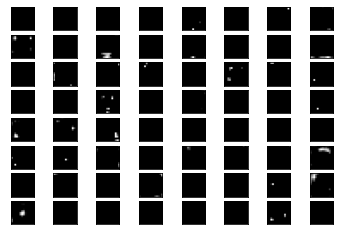

In [39]:

# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img('Test.png', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()